# **Colorizing Greyscale Images with a Generative Adversarial Network** 
Amir Bidva, Nima Aminpour, Prakhar Sinha

## Abstract

There are many old photographs in the world that were taken with black and white cameras. As such, recolonizing these photos has become a somewhat niche and popular hobby. Until recently, current methods of recolorization have been to recolor them meticulously by hand. In this project, given a grayscale image as input, our neural network aims to create a realistic and plausible colorization of that image. In the end, we aim to create realistic images using this method. We hypothesize that by using a convolutional neural network, we will be able to achieve the aforementioned goal. Specifically, by using a fully connected resnet as a backbone for our model and taking the first greyscale layer of the CIELAB color space as input into our neural network, we were able to achieve mostly realistic colorizations of the images with some exceptions. In the future, we would like to turn this implementation into a Generative Adversarial Network by adding a discriminator to our model to get even better results.


### Potential Data Sets: 
* CIFAR-10
* [Microsoft coco](https://cocodataset.org/#home)
* [ImageNet](https://www.image-net.org/)
* CelebA
* LFWpeople


## Resources
#### Papers/articles

* [DeOldify Neural Net](https://github.com/jantic/DeOldify)
* [Colorization Using ConvNet and GAN](http://cs231n.stanford.edu/reports/2017/pdfs/302.pdf)
* [Colorful Image Colorization](https://arxiv.org/abs/1603.08511)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
* [Diffusion models](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
* [Preception Loss](https://sanjivgautamofficial.medium.com/perceptual-loss-well-it-sounds-interesting-after-neural-style-transfer-d09a48b6fb7d)
* [FCN RESNET 50 backbone](https://arxiv.org/pdf/1411.4038.pdf)


#### Tutorial Websites
* [Neuromatch covnet tutorial](https://deeplearning.neuromatch.io/tutorials/W2D2_ConvnetsAndDlThinking/student/W2D2_Tutorial1.html)
* [Basic "explain like I'm 5" covnet tutorial](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a5)
* [GAN setup for dummies tutorial](https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-by-step-tutorial-fdefff170391#:~:text=GAN%20Training&text=Step%201%20%E2%80%94%20Select%20a%20number,both%20fake%20and%20real%20images.) 
* [Resnet tutorial](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)
* [MIT overview on Convolutional Neural Networks](https://www.youtube.com/watch?v=iaSUYvmCekI)
* [A step-by-step tutorial on how to nake a CNN](https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/)
* [Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html#)
* [PyTorch Dataloader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

## Hyperparameters

In [ ]:
learning_rate = 3e-4
number_of_epochs = 2
weight_decay = 0
kernel_size = 3
number_of_filters = [32,64,64]
loss_function = "MSELoss"
batch_size = 32

## Defining Dataset to be Used and File pathways for checkpoints

In [ ]:
dataset_name = "CelebA" #should be CIFAR10, CelebA, or LFWPeople
CHK_PATH = "model.pt"

## Install Dependencies

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from skimage import color, io
from torch.utils.data import random_split, Dataset, DataLoader
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import CelebA, CIFAR10, ImageNet, LFWPeople, Places365, STL10
from torchvision.io import read_image
from tqdm.auto import tqdm

%matplotlib inline

## Defining Helper Functions

In [ ]:
def Visualize(dataset,model):
    plt.ion()
    with torch.no_grad():

        # pick a random subset of images from the test set
        image_inds = np.random.choice(len(dataset), 25, replace=False)
        lab_batch = torch.stack([dataset[i][0] for i in image_inds])
        lab_batch = lab_batch.to(device)

        # predict colors (ab channels)
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

        lab_batch = lab_batch.cpu()
        predicted_lab_batch = predicted_lab_batch.cpu()

        # convert to rgb
        rgb_batch = []
        predicted_rgb_batch = []
        for i in range(lab_batch.size(0)):
            rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
            predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        # plot images
        fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
        ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[0].title.set_text('re-colored')
        ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[1].title.set_text('original')
        plt.show()

In [ ]:
# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

In [ ]:
def get_data(dataset_name):
    img_transform = transforms.Compose([
        transforms.Lambda(import_image)
        ])
    if dataset_name == "CIFAR10":
        test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
        train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "CelebA":
        train_dataset = CelebA('./data/CelebA', split='train', transform=img_transform, target_transform=None, download=True)
        test_dataset = CelebA('./data/CelebA', split='test', transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "LFWPeople":
        train_dataset = LFWPeople('./data/LFWPeople', split='train', transform=img_transform, target_transform=None, download=True)
        test_dataset = LFWPeople('./data/LFWPeople', split='test', transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "Places365":
        train_dataset = Places365('./data/LFWPeople', split='train-standard', small=True, transform=img_transform, target_transform=None, download=True)
        test_dataset = Places365('./data/LFWPeople', split='val', small=True, transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "STL10":
        train_dataset = STL10('./data/LFWPeople', split='train', transform=img_transform, target_transform=None, download=True)
        test_dataset = STL10('./data/LFWPeople', split='test', transform=img_transform, target_transform=None, download=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_dataset, test_dataset, train_dataloader, test_dataloader

## Confirm that Notebook is Running on GPU

In [ ]:
# Confirm we are running on GPU

torch.manual_seed(43)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"we are using {device}")

# torch.cuda.empty_cache()

we are using cuda


## Import the Datasets

In [ ]:
train_dataset, test_dataset, train_dataloader, test_dataloader = get_data("LFWPeople")
train_dataset2, test_dataset2, train_dataloader2, test_dataloader2 = get_data("STL10")

  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting ./data/LFWPeople/lfw-py/lfw-funneled.tgz to ./data/LFWPeople/lfw-py


  0%|          | 0/66403 [00:00<?, ?it/s]

  0%|          | 0/94727 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/LFWPeople/lfw-py/lfw-funneled.tgz
Extracting ./data/LFWPeople/lfw-py/lfw-funneled.tgz to ./data/LFWPeople/lfw-py


  0%|          | 0/28334 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/LFWPeople/lfw-py/lfw-names.txt


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/LFWPeople/stl10_binary.tar.gz to ./data/LFWPeople
Files already downloaded and verified


## Constructing the Convolutional Neural Network Architecture

In [ ]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()

        self.model = torchvision.models.segmentation.fcn_resnet50(True)
        self.model.classifier = torchvision.models.segmentation.fcn.FCNHead(2048, 2)
        self.model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return self.model(x)["out"]

model = ColorNet()
model = model.to(device)
criterion = nn.MSELoss()
for param in model.parameters():
    param.requires_grad = False
for param in model.model.classifier.parameters():
    param.requires_grad = True
for param in model.model.backbone.conv1.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

try:
    checkpoint = torch.load(CHK_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
except OSError as e:
    print(f"Check point doesn't exist on {CHK_PATH}.")

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

Check point doesn't exist on model.pt.


## Defining training and testing functions

In [ ]:
#@title train function
def train(model, train_dataloader, criterion, optimizer, number_of_epochs, starting_epoch = 0):
    model.train()
    loss_arr = []
    loss_per_epochs_list = []

    for epoch in tqdm(range(starting_epoch, starting_epoch + number_of_epochs), desc="epoch"):
        for lab_batch, _ in tqdm(train_dataloader, desc="batch"):
            lab_batch = lab_batch.to(device)

            # apply the color net to the luminance component of the Lab images
            # to get the color (ab) components
            predicted_ab_batch = model(lab_batch[:, 0:1, :, :])

            # loss is the L2 error to the actual color (ab) components
            loss = criterion(predicted_ab_batch, lab_batch[:, 1:3, :, :])
            loss_arr.append(loss.item())

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
        loss_per_epoch = test(model, train_dataloader, criterion)
        loss_per_epoch_validation = test(model, test_dataloader, criterion)
        loss_per_epochs_list.append(loss_per_epoch)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_per_epoch,
            'loss_validation': loss_per_epoch_validation
            }, CHK_PATH)
    
    return model, loss_arr, loss_per_epochs_list

In [ ]:
#@title test function
def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data[:, 0:1, :, :])
            test_loss += criterion(output, data[:, 1:3, :, :]).item()  # Sum up batch loss

    test_loss /= len(test_dataloader.dataset)
    return test_loss

## Testing and Training the Model

In [ ]:
# train_model, loss_arr, loss_per_epochs_list = train(model, train_dataloader, criterion, optimizer, number_of_epochs, epoch)

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.plot(loss_arr, label = 'batch')
# plt.plot(loss_per_epochs_list, label = 'epoch')
# plt.legend()
# plt.show()

In [ ]:
# Visualize(test_dataset, model)
# Visualize(train_dataset, model)

# Defining the discriminator

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 3


# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.AdaptiveAvgPool2d(1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device)
netG = ColorNet().to(device)

## Loss function
criterion = nn.BCELoss()
criterion_2 = nn.MSELoss()
## Optimizer assignment
lr = 1e-4
beta1 = 0.5
optimizerD =  torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG =  torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Training the GAN

In [ ]:
img_list = []
G_losses = []
D_losses = []
G_losses_MSE = []
G_MSE_losses_test = []
iters = 0
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader):
        
        image,_ = data
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = image.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
#         print(output.shape,label.shape)
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
#       
        # Generate fake image batch with G
        fake = netG(image[:, 0:1].to(device))
        fake = torch.cat([image[:, 0:1].to(device), fake], dim=1)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        c2 = criterion_2(fake,real_cpu)
        errG = criterion(output, label) + c2* 0.05
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        G_losses_MSE.append(c2.item())
        iters += 1
        
#     netG.eval()
#     image_test,_ = test_dataloader
#     output_test = netG(image_test[:, 0:1].to(device))
#     output_test = torch.cat([image_test[:, 0:1].to(device), output_test], dim=1)
#     test_loss = criterion_2(output_test, image_test.to(device))
#     print(f'test_loss_MSE{test_loss.item()}')
#     G_MSE_losses_test.append(test_loss.item())
    test_loss = test(netG, test_dataloader, criterion_2)
    G_MSE_losses_test.append(test_loss)
    print(f'test_loss_MSE : {test_loss}')
    netG.train()

        # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        

[0/5][0/298]	Loss_D: 1.3919	Loss_G: 8.7932	D(x): 0.4764	D(G(z)): 0.4750 / 0.4713
[0/5][50/298]	Loss_D: 0.6801	Loss_G: 6.3106	D(x): 0.7044	D(G(z)): 0.2764 / 0.2705
[0/5][100/298]	Loss_D: 0.3728	Loss_G: 7.6175	D(x): 0.8392	D(G(z)): 0.1780 / 0.1738
[0/5][150/298]	Loss_D: 0.3589	Loss_G: 9.1833	D(x): 0.8152	D(G(z)): 0.1413 / 0.1387
[0/5][200/298]	Loss_D: 0.2690	Loss_G: 8.3613	D(x): 0.8745	D(G(z)): 0.1242 / 0.1217
[0/5][250/298]	Loss_D: 0.2115	Loss_G: 8.8599	D(x): 0.8870	D(G(z)): 0.0865 / 0.0845
test_loss_MSE : 37.34678565954313
[1/5][0/298]	Loss_D: 0.3696	Loss_G: 8.8058	D(x): 0.9047	D(G(z)): 0.2320 / 0.1367
[1/5][50/298]	Loss_D: 0.2104	Loss_G: 7.1784	D(x): 0.8993	D(G(z)): 0.0977 / 0.0931
[1/5][100/298]	Loss_D: 0.6703	Loss_G: 5.8018	D(x): 0.6136	D(G(z)): 0.1499 / 0.4414
[1/5][150/298]	Loss_D: 0.3790	Loss_G: 8.1489	D(x): 0.9088	D(G(z)): 0.2434 / 0.1781
[1/5][200/298]	Loss_D: 0.3592	Loss_G: 8.4763	D(x): 0.8382	D(G(z)): 0.1624 / 0.1589
[1/5][250/298]	Loss_D: 1.2702	Loss_G: 6.0081	D(x): 0.3956	D

## Visualizing the Results

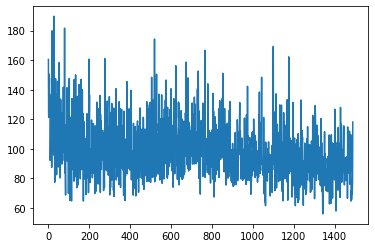

In [ ]:
plt.plot(G_losses_MSE)

/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return func(*args, **kwargs)


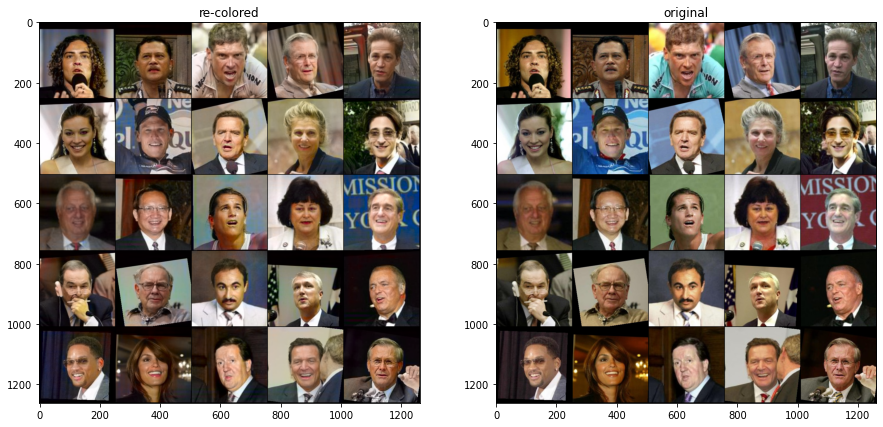

In [ ]:
Visualize(test_dataset, netG)